In [5]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.quantum_info import SparsePauliOp, entanglement_of_formation, DensityMatrix

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from scipy.optimize import minimize


import numpy as np
import matplotlib.pyplot as plt


from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties

from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import Estimator
from qiskit_aer.primitives import EstimatorV2 as EstimatorAer
from qiskit_aer import AerSimulator


from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2,
    SamplerV2 as Sampler,
    EstimatorOptions
)


from qiskit.visualization import plot_distribution


from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer



from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint

from numba import njit, jit

from entanglement_measures import GHZ_entanglmenetlike_measure, Multipartite_Negativity, multipartite_entanglement

In [16]:

#@jit
def initialize_LiH_vqe_chemical(intermolecular_distance= 1, mapper= JordanWignerMapper(), basis = 'sto-3g'):
    
    driver = PySCFDriver(atom=f"Li 0 0 0; H 0 0 {intermolecular_distance}", basis=basis)
    full_problem = driver.run()

    act_space_tf = ActiveSpaceTransformer(num_electrons= 2, num_spatial_orbitals= 2)

    problem = act_space_tf.transform(full_problem)

    mapper = ParityMapper(num_particles=(problem.num_alpha, problem.num_beta))

    

    pauli_hamiltonian = mapper.map(problem.hamiltonian.second_q_op())


    #then we generate the Ansatz
    init_state = HartreeFock(problem.num_spatial_orbitals,
                         problem.num_particles,
                         mapper)

    ansatz = UCCSD(problem.num_spatial_orbitals,
               problem.num_particles,
               mapper,
               initial_state= init_state)
    
    return ansatz, pauli_hamiltonian, problem


#@jit
def vqe_chemical_ansatz(estimator, ansatz, problem, mapper=JordanWignerMapper(), optimizer= SLSQP()):
    vqe = VQE(estimator= estimator,
              ansatz= ansatz,
              optimizer= optimizer)

    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))

    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem

    vqe.initial_point = initial_point.to_numpy_array()
    solver = GroundStateEigensolver(mapper, vqe)

    result = solver.solve(problem)

    gs_energy = result.total_energies[0]
    utilized_ansatz = result.groundstate[0]
    optimized_parameters = result.groundstate[1]

    optimal_ansatz = utilized_ansatz.assign_parameters(optimized_parameters)

    return gs_energy, optimal_ansatz



#@jit
def run_calculation_for_gs(swept_interval, estimator):

    distances = swept_interval

    num_calc = len( swept_interval )

    entanglement_list_max = np.zeros(num_calc)
    entanglement_list_total = np.zeros(num_calc)

    negativity_list_max = np.zeros(num_calc)
    negativity_list_total = np.zeros(num_calc)

    ghz_measure_list = np.zeros(num_calc)

    energiesH2_list = np.zeros(num_calc)


    
    for i, d in enumerate(swept_interval):

        ansatz_h2, pauli_ham_h2, prob = initialize_LiH_vqe_chemical(intermolecular_distance= d)

        gs_energy_d, optimal_ansatz_d = vqe_chemical_ansatz(estimator=estimator,
                                                            ansatz= ansatz_h2,
                                                            problem= prob)
        

        r = DensityMatrix(optimal_ansatz_d)

    

        energiesH2_list[i] = gs_energy_d

        entanglement_list_max[i] = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'max' )
        entanglement_list_total[i] = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'total')
        
        """
        negativity_list_max[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'max')
        negativity_list_total[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'total')
        """
        ghz_measure_list[i] = GHZ_entanglmenetlike_measure(optimal_ansatz_d)

    return energiesH2_list, entanglement_list_max, entanglement_list_total, negativity_list_max, negativity_list_total, ghz_measure_list

In [28]:
distances = np.arange(0.5, 4.25, 0.1)

estimator = Estimator()


energies_LiH, entgmax_LiH, entgtotal_LiH, negmax_LiH, negtotal_LiH, ghzmeasure_LiH = run_calculation_for_gs(swept_interval= distances, estimator= estimator)

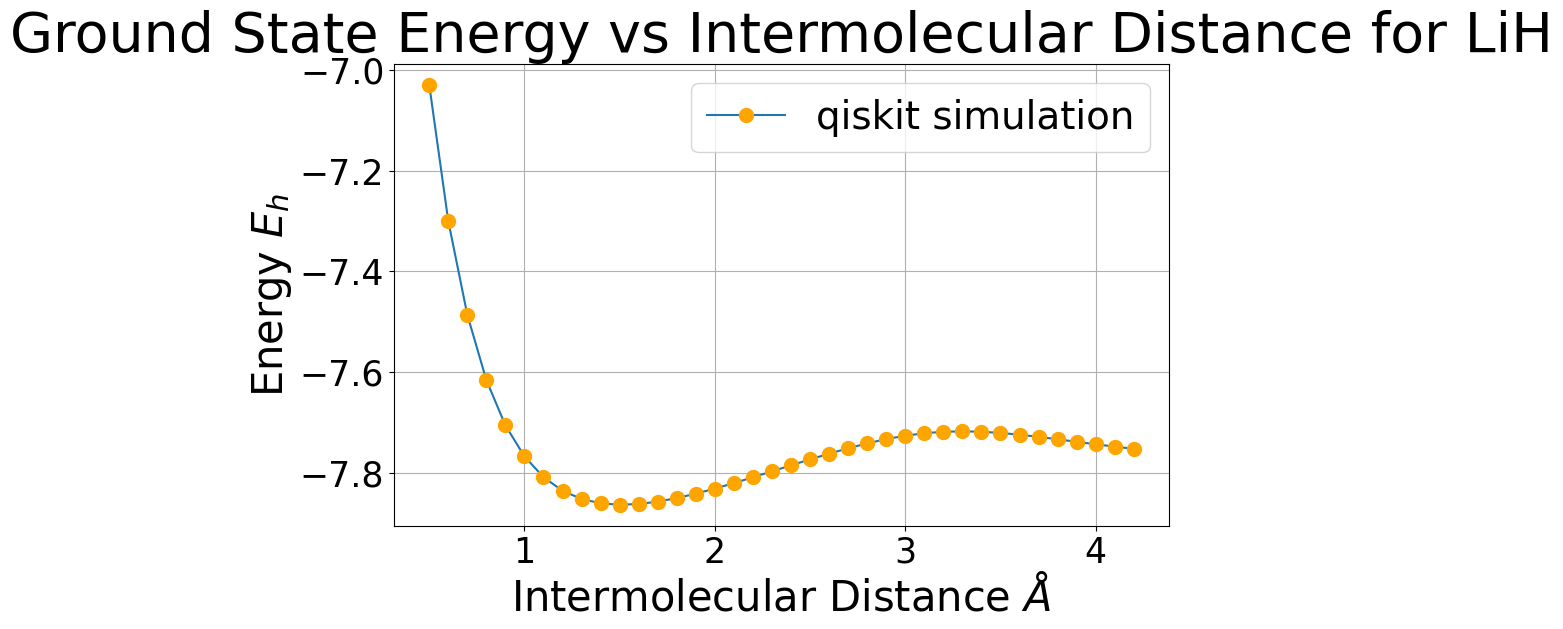

In [29]:
# Plotting the data

plt.figure(figsize=(10, 6))
plt.plot(distances, energies_LiH, marker='o', linestyle='-', label= 'qiskit simulation', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 10)
plt.xlabel(r'Intermolecular Distance $\AA$', fontsize= 30 )
plt.ylabel(r'Energy $E_h$', fontsize= 30)
plt.title(r'Ground State Energy vs Intermolecular Distance for LiH', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)
plt.minorticks_on()  # Enable minor ticks


plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

In [25]:
def final_stats(distances_list, energies_list):
    gs_energy = np.min(energies_list)

    gs_ener_indx = np.where(energies_list == gs_energy)[0][0]

    minimal_distance = distances_list[gs_ener_indx]

    print(f'Ground State Energy: {gs_energy} Hartree \n Distance of Equilibrium: {minimal_distance} Armstrongs')

In [26]:
final_stats(distances, energies_LiH)

Ground State Energy: -7.739662429358826 Hartree 
 Distance of Equilibrium: 0.9500000000000001 Armstrongs
